/work/csse463/202520/06/myenvAN/bin/python
Using device: cuda
Epoch [1/20] | Train Loss: 0.156596 | Val Loss: 0.112886
Epoch [2/20] | Train Loss: 0.103367 | Val Loss: 0.096407
Epoch [3/20] | Train Loss: 0.091322 | Val Loss: 0.087036
Epoch [4/20] | Train Loss: 0.083945 | Val Loss: 0.081072
Epoch [5/20] | Train Loss: 0.078886 | Val Loss: 0.077047
Epoch [6/20] | Train Loss: 0.075586 | Val Loss: 0.074221
Epoch [7/20] | Train Loss: 0.073140 | Val Loss: 0.072334
Epoch [8/20] | Train Loss: 0.071219 | Val Loss: 0.070452
Epoch [9/20] | Train Loss: 0.069692 | Val Loss: 0.068992
Epoch [10/20] | Train Loss: 0.068385 | Val Loss: 0.067875
Epoch [11/20] | Train Loss: 0.067186 | Val Loss: 0.066619
Epoch [12/20] | Train Loss: 0.066075 | Val Loss: 0.065876
Epoch [13/20] | Train Loss: 0.065041 | Val Loss: 0.064628
Epoch [14/20] | Train Loss: 0.064070 | Val Loss: 0.063787
Epoch [15/20] | Train Loss: 0.063121 | Val Loss: 0.062663
Epoch [16/20] | Train Loss: 0.062114 | Val Loss: 0.061533
Epoch [17/20] | Tra

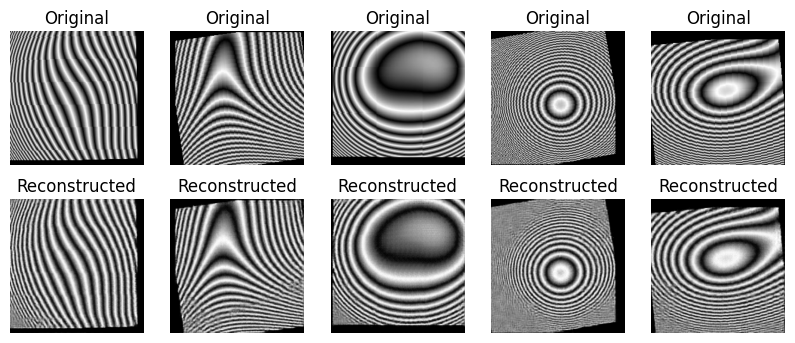

In [12]:
import sys
print(sys.executable)
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import glob

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class InterferogramDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform if transform else transforms.Compose([
            transforms.RandomRotation(10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.ToTensor(),
            transforms.Grayscale(1),
            transforms.Normalize((0.5,), (0.5,))
        ])
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        return image, image  # Autoencoder input and output are the same

def get_data_loaders(root_folder, batch_size=1000, num_workers=12):
    file_paths = glob.glob(os.path.join(root_folder, '*.jpg'))
    dataset = InterferogramDataset(file_paths)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 224 -> 112
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 112 -> 56
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 56 -> 28
        )
        
        # Decoder (Ensuring output is exactly 224x224)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),  # 28 -> 56
            
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),  # 56 -> 112
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # 112 -> 224 (Matches input size exactly)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def train_autoencoder(model, train_loader, val_loader, num_epochs=50, lr=1e-4):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, images).item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")
    
    # Save Model
    torch.save(model.state_dict(), 'autoencoder.pth')
    print("Model saved as autoencoder.pth")

def main():
    train_loader, val_loader = get_data_loaders('training2', batch_size=40, num_workers=24)
    model = Autoencoder()
    train_autoencoder(model, train_loader, val_loader, num_epochs=20)
    
    # Load and evaluate the trained model
    model.load_state_dict(torch.load('autoencoder.pth'))
    model.eval()
    
    print("Evaluating model on validation set...")
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            reconstructed = model(images)
            break  # Display only the first batch
    
    # Display images (original vs reconstructed)
    import matplotlib.pyplot as plt
    images = images.cpu().numpy()
    reconstructed = reconstructed.cpu().numpy()
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(5):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

if __name__ == '__main__':
    main()


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class InterferogramDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.cap = 5  # normalization factor
        
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Grayscale(1),
                transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
            ])
        else:
            self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        
        name = os.path.splitext(os.path.basename(img_path))[0]
        name = name.replace('n', '-').replace('p', '.')
        parts = name.split('_')
        params = np.zeros(8)
        for i, part in enumerate(parts[1:9]):
            params[i] = float(part[1:])
        
        params = torch.FloatTensor(params) / self.cap
        return image, params

def get_data_loaders(root_folder, batch_size=1000, num_workers=12):
    file_paths = glob.glob(os.path.join(root_folder, '*.jpg'))
    dataset = InterferogramDataset(file_paths)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader

# Define the encoder from the Autoencoder model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        return x

# Define the new model with fully connected layers for regression
class TransferLearningModel(nn.Module):
    def __init__(self, encoder):
        super(TransferLearningModel, self).__init__()
        self.encoder = encoder
        # self.fc_layers = nn.Sequential(
        #     nn.Linear(64 * 28 * 28, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 8)  # Output 8 coefficients
        # )
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Prevent overfitting
        
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),  # Another dropout layer
        
            nn.Linear(64, 8)  # Output 8 coefficients
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc_layers(x)
        return x

def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4):
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Add weight decay
    criterion = nn.MSELoss()
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, targets).item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {val_loss/len(val_loader):.6f}")
    
    # Save Model
    torch.save(model.state_dict(), 'transfer_learning_model.pth')
    print("Model saved as transfer_learning_model.pth")

def evaluate_model(model, val_loader):
    print("Evaluating model on validation set...")
    model.eval()
    with torch.no_grad():
        for images, actual_params in val_loader:
            images, actual_params = images.to(device), actual_params.to(device)
            predictions = model(images)
            break  # Display only the first batch

    # Denormalize predictions and actual values
    predictions = predictions.cpu().numpy() * 5 # Scale back to [-5, 5]
    actual_params = actual_params.cpu().numpy() * 5  # Scale back to [-5, 5]

    for i in range(min(5, predictions.shape[0])):
        print(f"\nSample {i+1}:")
        print(f"Predicted: {predictions[i]}")
        print(f"Actual:    {actual_params[i]}")
        print(f"Abs Error: {np.abs(predictions[i] - actual_params[i])}")

def main():
    train_loader, val_loader = get_data_loaders('training2', batch_size=100, num_workers=24)
    encoder = Encoder()
    model = TransferLearningModel(encoder)
    train_model(model, train_loader, val_loader, num_epochs=10)
    model.load_state_dict(torch.load('transfer_learning_model.pth'))
    evaluate_model(model, val_loader)

if __name__ == '__main__':
    main()


Using device: cuda
Epoch [1/10] | Train Loss: 0.333341 | Val Loss: 0.333384
Epoch [2/10] | Train Loss: 0.333160 | Val Loss: 0.333342
Epoch [3/10] | Train Loss: 0.332919 | Val Loss: 0.333591
Epoch [4/10] | Train Loss: 0.332035 | Val Loss: 0.334309
Epoch [5/10] | Train Loss: 0.330092 | Val Loss: 0.335339
Epoch [6/10] | Train Loss: 0.326679 | Val Loss: 0.338355
Epoch [7/10] | Train Loss: 0.320857 | Val Loss: 0.342920
Epoch [8/10] | Train Loss: 0.311954 | Val Loss: 0.349721
Epoch [9/10] | Train Loss: 0.300039 | Val Loss: 0.361964
Epoch [10/10] | Train Loss: 0.285863 | Val Loss: 0.367979
Model saved as transfer_learning_model.pth
Evaluating model on validation set...

Sample 1:
Predicted: [ 0.64630663 -0.19961074 -0.4081054  -1.129019   -1.2283124  -1.1418747
 -0.09798977 -0.17571323]
Actual:    [ 1.87117   -3.734817   3.524742   4.38361    3.566966  -0.344474
 -3.847794  -3.9490848]
Abs Error: [1.2248634 3.5352063 3.9328473 5.5126286 4.7952785 0.7974007 3.7498043
 3.7733715]

Sample 2:
Pre

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class InterferogramDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.cap = 5.0  # normalization factor
        
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Grayscale(1),
                transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
            ])
        else:
            self.transform = transform
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        image = self.transform(image)
        
        name = os.path.splitext(os.path.basename(img_path))[0]
        name = name.replace('n', '-').replace('p', '.')
        parts = name.split('_')
        params = np.zeros(8)
        for i, part in enumerate(parts[1:9]):
            params[i] = float(part[1:])
        
        params = torch.FloatTensor(params) / self.cap
        return image, params

def get_data_loaders(root_folder, batch_size=1000, num_workers=12):
    file_paths = glob.glob(os.path.join(root_folder, '*.jpg'))
    dataset = InterferogramDataset(file_paths)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_loader, val_loader

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 16, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),
        #     nn.Conv2d(16, 32, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),
        #     nn.Conv2d(32, 64, kernel_size=3, padding=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2)
        # )
    
    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        return x

# Define the new model with fully connected layers for regression
class TransferLearningModel(nn.Module):
    def __init__(self, encoder):
        super(TransferLearningModel, self).__init__()
        self.encoder = encoder
        
        # Get the output size dynamically
        dummy_input = torch.randn(1, 1, 224, 224)  # Assuming input images are 224x224
        with torch.no_grad():
            encoder_output = self.encoder(dummy_input)
            self.flattened_size = encoder_output.view(1, -1).shape[1]  # Compute flattened size
        
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),
            nn.BatchNorm1d(128),  # Normalizes activations
            nn.ReLU(),
            nn.Dropout(0.2),  # Prevent overfitting
        
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),  # Normalize activations
            nn.ReLU(),
            nn.Dropout(0.2),  # Another dropout layer
        
            nn.Linear(64, 8)  # Output 8 coefficients
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten dynamically
        x = self.fc_layers(x)
        return x


def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-4, patience=10):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, targets in train_loader:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images) * 5.0  # Rescale predictions back to [-5, 5]
            targets = targets * 5.0        # Rescale ground truth values
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        num_val_batches = 0
        with torch.no_grad():
            for images, targets in val_loader:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, targets).item()
                num_val_batches += 1
        
        val_loss /= num_val_batches  # Normalize validation loss
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss/len(train_loader):.6f} | Val Loss: {val_loss:.6f}")
        
        # Early stopping condition
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'transfer_learning_model.pth')  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    

    # Save Model
    torch.save(model.state_dict(), 'transfer_learning_model.pth')
    print("Model saved as transfer_learning_model.pth")

def evaluate_model(model, val_loader):
    print("Evaluating model on validation set...")
    model.eval()
    with torch.no_grad():
        for images, actual_params in val_loader:
            images, actual_params = images.to(device), actual_params.to(device)
            predictions = model(images)
            break  # Display only the first batch

    # Denormalize predictions and actual values
    predictions = predictions.cpu().numpy() * 5 # Scale back to [-5, 5]
    actual_params = actual_params.cpu().numpy() * 5  # Scale back to [-5, 5]

    for i in range(min(5, predictions.shape[0])):
        print(f"\nSample {i+1}:")
        print(f"Predicted: {predictions[i]}")
        print(f"Actual:    {actual_params[i]}")
        print(f"Abs Error: {np.abs(predictions[i] - actual_params[i])}")

def main():
    train_loader, val_loader = get_data_loaders('training2', batch_size=40, num_workers=24)

    # Load full autoencoder model state dict
    autoencoder_state_dict = torch.load('autoencoder.pth', map_location=device)

    # Create an empty encoder model (without redefining Autoencoder)
    encoder = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(16, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    # Extract only encoder weights from the saved model
    encoder_state_dict = {k.replace("encoder.", ""): v for k, v in autoencoder_state_dict.items() if "encoder" in k}

    # Load pre-trained encoder weights
    encoder.load_state_dict(encoder_state_dict)
    encoder.eval()  # Set encoder to evaluation mode

    # Create Transfer Learning Model
    model = TransferLearningModel(encoder)

    # Freeze the encoder layers to prevent modification
    for param in model.encoder.parameters():
        param.requires_grad = False

    # Train the new model with the pre-trained encoder
    train_model(model, train_loader, val_loader, num_epochs=50, patience=10)
    model.load_state_dict(torch.load('transfer_learning_model.pth'))
    evaluate_model(model, val_loader)

if __name__ == '__main__':
    main()



Using device: cuda


NameError: name 'os' is not defined

Using device: cuda


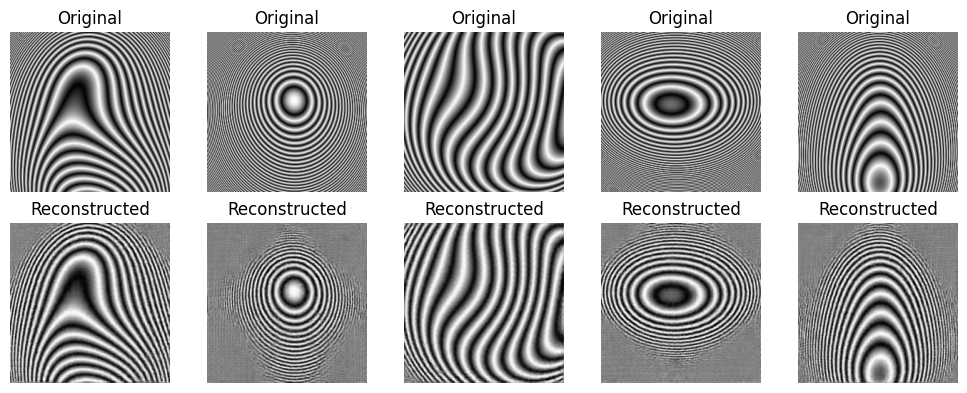

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import glob
import os

# Define the Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load trained model
model = Autoencoder().to(device)
model.load_state_dict(torch.load('autoencoder.pth', map_location=device))  # Load weights
model.eval()

# Define image transformation (same as used in training)
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load sample images from dataset
image_paths = glob.glob(os.path.join('training2', '*.jpg'))[:10]  # Load first 10 images
original_images = [Image.open(img_path) for img_path in image_paths]
tensor_images = torch.stack([transform(img) for img in original_images])

# Move images to device
tensor_images = tensor_images.to(device)

# Run model inference
with torch.no_grad():
    reconstructed_images = model(tensor_images)

# Convert tensors to numpy for visualization
original_images_np = tensor_images.cpu().numpy()
reconstructed_images_np = reconstructed_images.cpu().numpy()

# Plot results
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axes[0, i].imshow(original_images_np[i].squeeze(), cmap='gray')
    axes[0, i].set_title("Original")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(reconstructed_images_np[i].squeeze(), cmap='gray')
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()



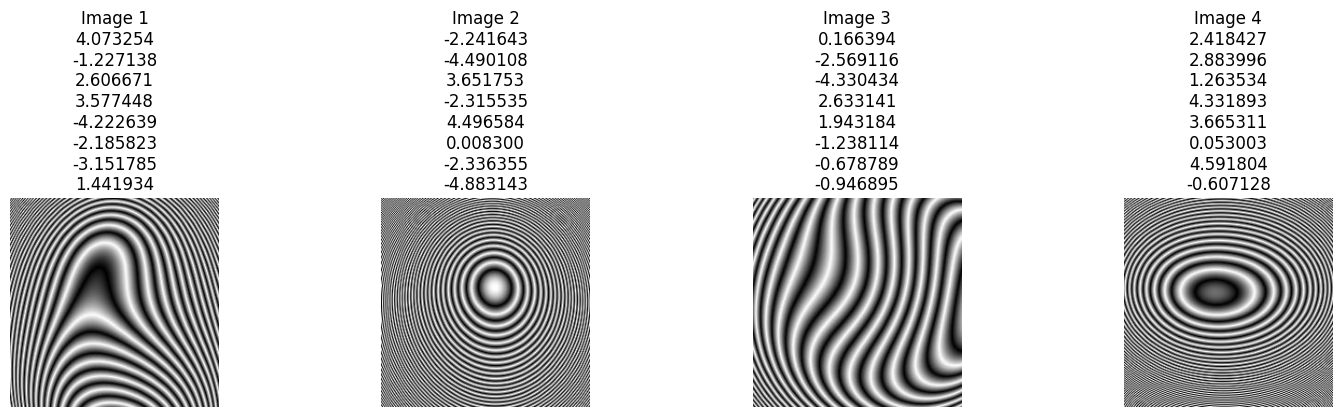

In [4]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import glob
import os
import numpy as np
import re

# Define image transformation
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load sample images from dataset
image_paths = glob.glob(os.path.join('training2', '*.jpg'))[:4]  # Load first 4 images
original_images = [Image.open(img_path) for img_path in image_paths]
tensor_images = [transform(img).numpy() for img in original_images]

# Extract coefficients from filenames (assumes format 'img_DX_CX_BX_GX_FX_JX_EX_IX.jpg')
def extract_coeffs(filename):
    matches = re.findall(r'[DCBGFJEI]([-n]?\d+p\d+)', os.path.basename(filename))
    coefficients = [match.replace('n', '-').replace('p', '.') for match in matches]
    return coefficients if len(coefficients) == 8 else ["N/A"] * 8  # Ensure 8 values

coefficients = [extract_coeffs(img_path) for img_path in image_paths]

# Convert to numpy arrays for visualization
original_images_np = np.array(tensor_images)

# Plot images with coefficients
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for i in range(4):
    axes[i].imshow(original_images_np[i].squeeze(), cmap='gray')
    coeff_text = "\n".join(coefficients[i])
    axes[i].set_title(f"Image {i+1}\n{coeff_text}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


